In [244]:
from mysql.connector import connect, Error
from getpass import getpass

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [278]:
try:
    conn = connect(host='localhost', user='root', password='password', database='mydoc')
except Error as e:
    print(e)

### Ensure Correct Login

In [246]:
# Enter Users First Name, Last Name, Password

def check_login(users_firstname, users_lastname,users_password):

    query = """SELECT users.password,users.user_id,users.user_type FROM users where users.firstname = %s and users.lastname = %s;"""

    with conn.cursor() as cursor:
        #cursor.executemany(query,[(users_firstname, users_lastname)])
        cursor.execute(query,(users_firstname, users_lastname, ))
        result = cursor.fetchall()
        
    if(users_password == result[0][0]):
        print("You have logged in successfully")
    else:
        print("You have entered the wrong username or password. Please try again")
        
    return result[0][1],result[0][2]

In [247]:
users_firstname = 'Kahaleel'
users_lastname = 'Boorer'

users_password = 'tYBNSC0ScPw2'


users_userid, users_usertype = check_login(users_firstname, users_lastname,users_password)

You have logged in successfully


In [248]:
users_userid, users_usertype

(1, 'patient')

### Filter the Hospital and Department to View Doctors Available on a particular day

Select Hospital

In [249]:
query = """SELECT hospitals.name, hospitals.city from hospitals;"""

with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()

df = pd.DataFrame(result)
df.columns = ["Hospital", "City"]
display(df)

,Hospital,City
0,Cormier LLC,Houston
1,Klein-Wisoky,Miami
2,Dietrich-Bogisich,Fort Wayne
3,Gusikowski Inc,Anderson
4,"Braun, Harris and Gislason",Springfield
5,Corkery-Christiansen,Oklahoma City
6,Walter-Wehner,Austin
7,Cole-Block,Hicksville
8,"Grady, Goyette and Hilpert",North Hollywood
9,Fadel-Towne,Sioux Falls


In [250]:
hospital_name = 'Cormier LLC'

In [251]:
def get_hospital_id(hospital_name):
    query = """SELECT hospitals.hospital_id from hospitals where hospitals.name = %s;"""

    with conn.cursor() as cursor:
        cursor.execute(query,(hospital_name, ))
        result = cursor.fetchall()
        
    return result[0][0]

hospital_id = get_hospital_id(hospital_name)
hospital_id

1

Select Department

In [252]:
query = """SELECT departments.name,departments.department_spec  
            FROM hosp_dept, departments
            WHERE hosp_dept.department_id = departments.department_id AND
            hosp_dept.hospital_id = %s;"""

with conn.cursor() as cursor:
    cursor.execute(query,(hospital_id, ))
    result = cursor.fetchall()
    
df = pd.DataFrame(result)
df.columns = ["Department Name", "Description"]

display(df)

,Department Name,Description
0,Department of Paediatrics,Paediatrics
1,Department of Dental care,Dental


In [253]:
dept_name = 'Department of Paediatrics'

In [254]:
def get_dept_id(dept_name):
    query = """SELECT departments.department_id from departments where departments.name = %s;"""

    with conn.cursor() as cursor:
        cursor.execute(query,(dept_name, ))
        result = cursor.fetchall()
        
    return result[0][0]

dept_id = get_dept_id(dept_name)
dept_id

5

### View Previous Appointments

In [255]:
query = "SELECT * FROM previous_appointments_user"

with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()

In [256]:
df = pd.DataFrame(result)
df.columns = ["Appointment ID","Appointment Date","Appointment Time","Doctor Name", "Hospital Name"]

display(df)

,Appointment ID,Appointment Date,Appointment Time,Doctor Name,Hospital Name
0,4,2020-08-22,0 days 10:00:00,Sophronia Brighty,Gusikowski Inc
1,1,2022-11-28,0 days 13:00:00,Amie Coltman,Cormier LLC
2,16,2022-11-30,0 days 20:00:00,Amie Coltman,Cormier LLC


### Book an Appointment with the doctor of your choice (subject to availability)

Select Doctor

In [257]:
doctor_id = '11'

Select Date for booking Appointment

In [258]:
appointment_date = '2022-11-30'

Select Appointment Time

In [259]:
appointment_time = '20:00:00'

In [260]:
def book_appointment(users_userid,doctor_id,hospital_id,appointment_time,appointment_date):
    status_code = ""
    message = ""
    with conn.cursor() as cursor:
        cursor.callproc('bookAppointment',(users_userid,doctor_id,hospital_id,appointment_time,appointment_date,status_code,message))
        results = cursor.stored_results()
        
        for result in results:
            print(result.fetchall()[0][1])
    
book_appointment(users_userid,doctor_id,hospital_id,appointment_time,appointment_date)

Doctor Not Available. Please Book for another time


In [261]:
conn.commit()

### Doctor can view their schedule

In [262]:
query = """SELECT * FROM mydoc.this_week_appointments_mydoc"""

with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()

In [263]:
df = pd.DataFrame(result)
df.columns = ["Hospital ID", "Hospital Name", "Doctor ID", "Doctor Name", "User ID", "Patient Name", "Appointment ID", "Appointment Date", "Appointment Date"]

display(df)

,Hospital ID,Hospital Name,Doctor ID,Doctor Name,User ID,Patient Name,Appointment ID,Appointment Date,Appointment Date
0,1,Cormier LLC,11,Amie Coltman,1,Kahaleel Boorer,1,2022-11-28,0 days 13:00:00
1,1,Cormier LLC,11,Amie Coltman,2,Harmon Mayell,2,2022-11-28,0 days 14:00:00
2,1,Cormier LLC,11,Amie Coltman,3,Joycelin Toon,3,2022-11-28,0 days 17:00:00
3,1,Cormier LLC,11,Amie Coltman,1,Kahaleel Boorer,16,2022-11-30,0 days 20:00:00


### Generate the Bill After Diagnosis

<b>Here while generating the bill, we are giving a discount of 10% if the Final bill is above 500.</b>

<b>Insertion of diagnosis to show the trigger</b>

In [264]:
query = "insert into diagnosis (appointment_id, prescription_id, lab_test_id) values (1, 1, 1);"
with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()

IntegrityError: 1062 (23000): Duplicate entry '1-1-1' for key 'diagnosis.PRIMARY'

In [265]:
query = "SELECT * FROM mydoc.generate_bill_view"
with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()

In [266]:
df = pd.DataFrame(result)
df.columns = ["Appointment ID","Appointment Date","Appointment Time","Patient Name", "Doctor Name","Hospital Name", "Visit Charges", "Prescription Amount", "Lab Test Amount", "Final Bill"]

display(df.iloc[:1])

,Appointment ID,Appointment Date,Appointment Time,Patient Name,Doctor Name,Hospital Name,Visit Charges,Prescription Amount,Lab Test Amount,Final Bill
0,1,2022-11-28,0 days 13:00:00,Kahaleel Boorer,Amie Coltman,Cormier LLC,150.0,1206.24,50.76,1266.3


In [267]:
conn.commit()

### Admin

<b> Shows the admin the working status of a docto at a specific date & time</b>

In [268]:
def onCallDoctors( doctor_id,appointment_date, appointment_time):
    message = ""
    with conn.cursor() as cursor:
        cursor.callproc('onCallDoctors',(doctor_id, appointment_date, appointment_time, message))
        results = cursor.stored_results()
        
        for result in results:
            print(result.fetchall()[0][0])
    
onCallDoctors( doctor_id,appointment_date, appointment_time )

Doctor is Working Now


<b> Shows the admin the number of doctors that are working on a given day. </b>

In [269]:
def numDoctors( appointment_date):
    num = ""
    with conn.cursor() as cursor:
        cursor.callproc('numDoctors',( appointment_date, num))
        results = cursor.stored_results()
        
        for result in results:
            print(result.fetchall()[0][0])
    
numDoctors( appointment_date )

wednesday_work
5


<b> Shows the details of all the users except their sensitive information such as SNN & password. This includes the patients and doctors. </b>

In [279]:
query = """SELECT * FROM mydoc.userinfo"""
with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()

In [280]:
df = pd.DataFrame(result)
df.columns = ["User ID","Full Name","Gender","Date of Birth", "Address", "City", "State", "Pincode","Phone Number","Email ID"]

display(df)

,User ID,Full Name,Gender,Date of Birth,Address,City,State,Pincode,Phone Number,Email ID
0,1,Kahaleel Boorer,Bigender,2022-11-07,8 Homewood Alley,Milwaukee,Wisconsin,53210,262-460-1044,kboorer0@mapquest.com
1,2,Harmon Mayell,Male,2022-10-23,20 Helena Park,West Hartford,Connecticut,06127,860-592-5042,hmayell1@yandex.ru
2,3,Joycelin Toon,Female,2022-09-28,11841 Grayhawk Road,Oklahoma City,Oklahoma,73147,405-938-3497,jtoon2@imageshack.us
3,4,Gardner Guinness,Male,2022-09-23,6 Banding Court,New York City,New York,10155,917-659-0187,gguinness3@nsw.gov.au
4,5,Brendon Capron,Male,2022-09-21,8 Hauk Terrace,Bronx,New York,10474,917-709-4247,bcapron4@soup.io
5,6,Rollins Janeczek,Male,2022-09-24,12088 Ridgeview Terrace,Peoria,Illinois,61635,309-329-2528,rjaneczek5@about.com
6,7,Andie Ilden,Female,2022-10-11,88597 Mayfield Drive,Harrisburg,Pennsylvania,17140,717-508-1402,ailden6@howstuffworks.com
7,8,Aurora D'Adamo,Female,2022-11-07,048 Valley Edge Alley,Dayton,Ohio,45490,937-374-0423,adadamo7@godaddy.com
8,9,Giuseppe Parade,Male,2022-10-03,961 Farmco Park,Suffolk,Virginia,23436,757-473-2755,gparade8@youtu.be
9,10,Zorine Leveridge,Female,2022-09-25,900 Victoria Alley,Amarillo,Texas,79176,806-904-1874,zleveridge9@wunderground.com


In [272]:
def numAppointmentsToday(appointment_date,hospital_id):
    
    with conn.cursor(buffered=True) as cursor:
        data = (appointment_date, hospital_id)
        query = '''
        select numAppointmentsToday('%s',%s) as 'Number of Doctors Today';
        '''%data
        cursor.execute(query)
        
        myresult = cursor.fetchall()
    
        for result in myresult:
            print(result)
numAppointmentsToday("2022-11-30",1)

(4,)


### EXPLORATORY DATA ANALYSIS

<b> Here we are showing the pie chart for the different gender of users which can be both patients and doctors. /b<>

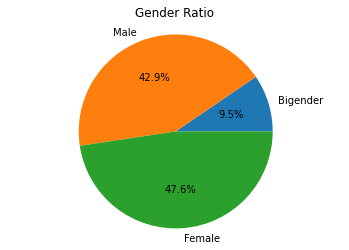

In [273]:
query = "SELECT gender,count(*) FROM users GROUP BY gender"

with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()
    
gender_ratio_df = pd.DataFrame(result)
gender_ratio_df.columns = ["Gender", "Count"]

plt.pie(gender_ratio_df["Count"], labels=gender_ratio_df["Gender"], autopct='%1.1f%%')
plt.title('Gender Ratio')
plt.axis('equal')
plt.show()

<b> The bar chart for the top 5 departments having the highest number of doctors.</b>

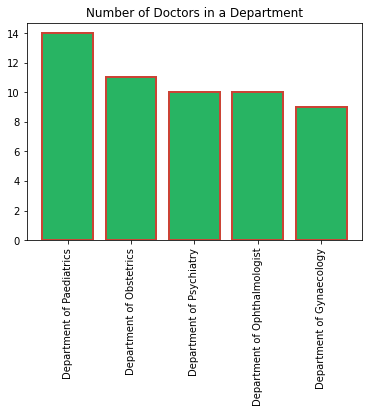

In [274]:
query = """SELECT name as Department_Name , sum(number_doctors)
    from departments
    group by name
    order by sum(number_doctors) desc
    limit 5;"""

with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()
    
name_df = pd.DataFrame(result)
name_df.columns = ["name_of_department", "number_of_doctors"]

plt.bar(name_df["name_of_department"], name_df["number_of_doctors"], color ="#28B463", edgecolor ="#CB4335", linewidth = 2)
plt.title('Number of Doctors in a Department')
plt.xticks(rotation=90)
plt.show()

<b> Shows the bar chart which represents the State wise Distribution of number of Hospitals.</b>

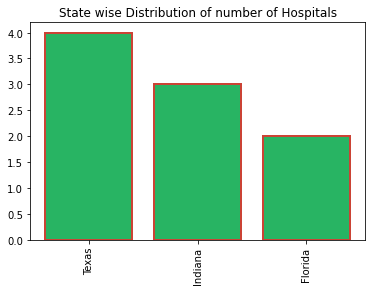

In [275]:
query = """SELECT state,count(state) as num
           FROM hospitals
           GROUP BY state
           ORDER BY count(state) desc
           LIMIT 3"""

with conn.cursor() as cursor:
    cursor.execute(query)
    result = cursor.fetchall()
    
name_df = pd.DataFrame(result)
name_df.columns = ["state", "num"]

plt.bar(name_df["state"], name_df["num"], color ="#28B463", edgecolor ="#CB4335", linewidth = 2)
plt.title('State wise Distribution of number of Hospitals')
plt.xticks(rotation=90)
plt.show()

In [276]:
conn.close()